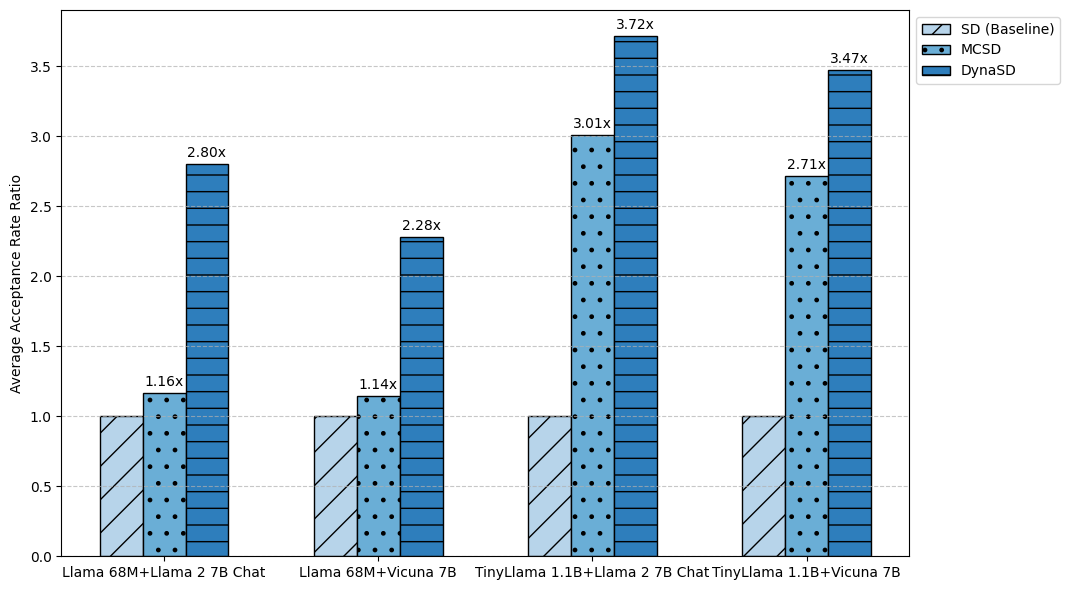

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load data for MT-bench, trivia-qa, and alpaca-clean datasets
datasets = ['mt_bench', 'trivia_qa', 'alpaca']

# Placeholder for combined data across all datasets
combined_data_list = []

for dataset in datasets:
    # Define file paths for each dataset
    sd_data_path = f'/home/yixiaozeng/DynaSD/results/{dataset}/sd_inference_{dataset}_probabilistic.csv'
    mcsd_data_path = f'/home/yixiaozeng/DynaSD/results/{dataset}/mcsd_inference_{dataset}_probabilistic.csv'
    dynasd_data_path = f'/home/yixiaozeng/DynaSD/results/with_temperature0.7_old_32precision/4&4/dynasd_inference_{dataset}_probabilistic.csv'

    # Load data for SD, MCSD, and DynaSD methods
    sd_data = pd.read_csv(sd_data_path, header=None, names=['draft_model', 'target_model', 'speed', 'acc_rate'])
    mcsd_data = pd.read_csv(mcsd_data_path, header=None, names=['draft_model', 'target_model', 'speed', 'acc_rate'])
    dynasd_data = pd.read_csv(dynasd_data_path, header=None, names=['draft_model', 'target_model', 'speed', 'acc_rate'])

    # Merge SD acceptance rate into MCSD and DynaSD for baseline comparison
    mcsd_data = mcsd_data.merge(sd_data[['target_model', 'acc_rate']], on='target_model', suffixes=('', '_sd'))
    dynasd_data = dynasd_data.merge(sd_data[['target_model', 'acc_rate']], on='target_model', suffixes=('', '_sd'))

    # Calculate acceptance rate ratio for each method relative to SD
    mcsd_data['acceptance_rate_ratio'] = mcsd_data['acc_rate'] / mcsd_data['acc_rate_sd']
    dynasd_data['acceptance_rate_ratio'] = dynasd_data['acc_rate'] / dynasd_data['acc_rate_sd']
    sd_data['acceptance_rate_ratio'] = sd_data['acc_rate'] / sd_data['acc_rate']  # SD ratio is 1

    # Simplify model names
    model_short_names = {
        'TinyLlama/TinyLlama-1.1B-Chat-v1.0': 'TinyLlama 1.1B',
        'lmsys/vicuna-7b-v1.5': 'Vicuna 7B',
        'meta-llama/Llama-2-7b-chat-hf': 'Llama 2 7B Chat',
        'JackFram/llama-68m': 'Llama 68M',
    }

    sd_data.replace({'draft_model': model_short_names, 'target_model': model_short_names}, inplace=True)
    mcsd_data.replace({'draft_model': model_short_names, 'target_model': model_short_names}, inplace=True)
    dynasd_data.replace({'draft_model': model_short_names, 'target_model': model_short_names}, inplace=True)

    # Add dataset to identify rows later for averaging
    sd_data['dataset'] = dataset
    mcsd_data['dataset'] = dataset
    dynasd_data['dataset'] = dataset

    # Concatenate into a unified DataFrame for each dataset
    combined_data = pd.concat([
        sd_data[['draft_model', 'target_model', 'acceptance_rate_ratio', 'dataset']].assign(method='SD'),
        mcsd_data[['draft_model', 'target_model', 'acceptance_rate_ratio', 'dataset']].assign(method='MCSD'),
        dynasd_data[['draft_model', 'target_model', 'acceptance_rate_ratio', 'dataset']].assign(method='DynaSD')
    ])
    combined_data_list.append(combined_data)

# Concatenate all dataset data and compute average acceptance rate ratio per model pair
combined_data_all = pd.concat(combined_data_list)
average_acceptance_rate_data = combined_data_all.groupby(['draft_model', 'target_model', 'method']).agg({'acceptance_rate_ratio': 'mean'}).reset_index()

# Prepare data for plotting
average_acceptance_rate_data['label'] = average_acceptance_rate_data['draft_model'] + '+' + average_acceptance_rate_data['target_model']
average_acceptance_rate_data.sort_values(by=['label', 'acceptance_rate_ratio'], ascending=[True, False], inplace=True)

labels = average_acceptance_rate_data['label'].unique()
x = range(len(labels))

# Define colors for each method
color_scale = plt.cm.Blues
color_dynasd = color_scale(0.7)
color_mcsd = color_scale(0.5)
color_sd = color_scale(0.3)

plt.figure(figsize=(12, 6))
width = 0.2

# Plotting bars with hatch patterns for each method
plt.bar(x, [1] * len(x), width=width, label='SD (Baseline)', color=color_sd, align='center', edgecolor='black', hatch='/')
plt.bar([p + width for p in x], average_acceptance_rate_data[average_acceptance_rate_data['method'] == 'MCSD']['acceptance_rate_ratio'], 
        width=width, label='MCSD', color=color_mcsd, align='center', edgecolor='black', hatch='.')
plt.bar([p + 2 * width for p in x], average_acceptance_rate_data[average_acceptance_rate_data['method'] == 'DynaSD']['acceptance_rate_ratio'], 
        width=width, label='DynaSD', color=color_dynasd, align='center', edgecolor='black', hatch='-')

# Label and annotate plot
plt.ylabel('Average Acceptance Rate Ratio')
plt.xticks([p + 1 * width for p in x], labels, rotation=0, ha='center', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc='best', bbox_to_anchor=(1, 1))

# Annotate each bar with the average acceptance rate ratio value
for i, v in enumerate(average_acceptance_rate_data[average_acceptance_rate_data['method'] == 'DynaSD']['acceptance_rate_ratio']):
    plt.text(i + 2 * width, v + 0.05, f"{v:.2f}x", color='black', ha='center', fontsize=10)
for i, v in enumerate(average_acceptance_rate_data[average_acceptance_rate_data['method'] == 'MCSD']['acceptance_rate_ratio']):
    plt.text(i + width, v + 0.05, f"{v:.2f}x", color='black', ha='center', fontsize=10)

plt.tight_layout(rect=[0, 0, 0.9, 1])

# Save the plot
plt.savefig('acceptance_rate_ratio.pdf')
